In [1]:
import oggm.cfg as cfg

In [2]:
# This allows changes in chakra.py to be automatically re-imported
# (this is tricky with OOP though, to be used with care)
%load_ext autoreload
%autoreload 1
%aimport chakra

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import stats


In [4]:
# Get the default params
from oggm import cfg
cfg.initialize(logging_level='WORKFLOW')
cfg.PARAMS['cfl_number'] = 0.01  # less numerical instabilities
cfg.PARAMS['use_multiprocessing'] = False
from oggm import graphics

/home/ruitang/miniconda3/envs/oggm_env/lib/python3.8/site-packages/oggm/cfg.py:386: FutureWarning: In future versions of OGGM, the logging config WORKFLOW will no longer print ERROR or WARNING messages, but only high level information (i.e. hiding potential errors in your code but also avoiding cluttered log files for runs with many expected errors, e.g. global runs). If you want to obtain a similar logger behavior as before, set `logging_level='WARNING'`, which will print high level info as well as errors and warnings during the run. If you want to use the new behavior and suppress this warning, set `logging_level='WORKFLOW'` and `future=True`.
  warnings.warn(msg, category=FutureWarning)
2023-05-30 10:34:44: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-05-30 10:34:44: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-05-30 10:34:44: oggm.cfg: Multiprocessing: using all available processors (N=8)
2023-05-30 10:34:4

## Velocity-forced viscoplastic calving

First, we'll define some constants and a preliminary function for yield strength.  Then, we'll write a function that takes profiles and velocity from any model and outputs a viscoplastic frontal ablation rate.

In [5]:
## Global constants
G = 9.8 # acceleration due to gravity in m/s^2
RHO_ICE = 920.0 #ice density kg/m^3
RHO_SEA = 1020.0 #seawater density kg/m^3

def tau_y(tau0=150e3, yield_type='constant', bed_elev=None, thick=None, mu=0.01):
    """Functional form of yield strength.
    Can do constant or Mohr-Coulomb yield strength.  Ideally, the glacier's yield type
    ('constant' or 'variable') would be saved in a model instance.

    Parameters
    ----------
    tau0: float, optional
        Initial guess for yield strength [Pa]. Default is 150 kPa.
    yield_type: str, optional
        'constant' or 'variable' (Mohr-Coulomb) yielding. Default is constant.
    bed_elev: float, optional
        Bed elevation, dimensional [m]. The default is None.
    thick: float, optional
        Ice thickness, dimensional [m]. The default is None.
    mu: float, optional
        Mohr-Coulomb cohesion, a coefficient between 0 and 1. Default is 0.01.

    Returns
    -------
    tau_y: float
        The yield strength for these conditions.
    """
    if yield_type=='variable':
        try:
            if bed_elev<0:
                D = -1*bed_elev #Water depth D the nondim bed topography value when Z<0
            else:
                D = 0
        except:
            print('You must set a bed elevation and ice thickness to use variable yield strength.')
        N = RHO_ICE*G*thick - RHO_SEA*G*D #Normal stress at bed
        ty = tau0 + mu*N
    else: #assume constant if not set
        ty = tau0
    return ty


def balance_thickness(yield_strength, bed_elev):
    """Ice thickness such that the stress matches the yield strength.
    
    Parameters
    ----------
    yield_strength: float
        The yield strength near the terminus.  
        If yield type is constant, this will of course be the same everywhere.  If yield type is 
        variable (Mohr-Coulomb), the yield strength at the terminus could differ from elsewhere.
    bed_elev: float
        Elevation of glacier bed at the terminus
        
    Returns
    -------
    Hy: float
        The ice thickness for stress balance at the terminus.
    """
    
    if bed_elev<0:
        D = -1*bed_elev
    else:
        D = 0
    return (2*yield_strength/(RHO_ICE*G)) + np.sqrt((RHO_SEA*(D**2)/RHO_ICE)+(2*yield_strength/(RHO_ICE*G)))
## TODO: Check on exponent on last term.  In Ultee & Bassis 2016, this is squared, but in Ultee & Bassis 2020 supplement, it isn't.
    

In [6]:
def fa_from_velocity(profile, model_velocity, terminus_mb=None, verbose=False,
                    tau0=150e3, yield_type='constant', mu=0.01,
                    trim_profile=0):
    """Compute frontal ablation given velocity forcing
    
    Parameters
    ----------
    profile: NDarray
        The current profile (x, surface, bed) as calculated by the base model
        Unlike core SERMeQ, these should be DIMENSIONAL [m].
    model_velocity: array
        Velocity along the flowline [m/a] as calculated by the base model 
        Should have values for the points nearest the terminus...otherwise doesn't matter if this
        is the same shape as the profile array.
    terminus_mb : float, optional
        Mass balance nearest the terminus [m/a]. Default None...TODO: set default behavior
    verbose: Boolean, optional
        Whether to print component parts for inspection.  Default False.
        
    tau0: float, optional
        This glacier's yield strength [Pa]. Default is 150 kPa.
    yield_type: str, optional
        'constant' or 'variable' (Mohr-Coulomb) yielding. Default is constant.
    mu: float, optional
        Mohr-Coulomb cohesion, a coefficient between 0 and 1. Default is 0.01.
        Only used if we have variable yield
        
    trim_profile: int, optional
        How many grid cells at the end of the profile to ignore.  Default is 1.
        If the initial profile is set by k-calving (as in testing) there can be a 
        weird cliff shape with very thin final grid point and large velocity gradient
    
    Returns
    -------
    fa_viscoplastic: float
        Frontal ablation rate [m/a] based on viscoplastic assumptions
    """
    last_index=-1*(trim_profile+1) ## remove lowest cells if needed
        
    ## Ice thickness and yield thickness nearest the terminus
    se_terminus = profile[1][last_index]
    bed_terminus = profile[2][last_index]
    H_terminus = se_terminus - bed_terminus
    tau_y_terminus = tau_y(tau0=tau0, bed_elev=bed_terminus, thick=H_terminus,yield_type=yield_type)
    Hy_terminus = balance_thickness(yield_strength=tau_y_terminus, bed_elev=bed_terminus)
    U_terminus = model_velocity[last_index] ## velocity, assuming last point is terminus
    
    ## Ice thickness and yield thickness at adjacent point
    se_adj = profile[1][last_index-1]
    bed_adj = profile[1][last_index-1]
    H_adj = se_adj - bed_adj
    tau_y_adj = tau_y(tau0=tau0,bed_elev=bed_adj, thick=H_adj,yield_type=yield_type)
    Hy_adj = balance_thickness(yield_strength=tau_y_adj, bed_elev=bed_adj)
    U_adj = model_velocity[last_index-1]
    
    
    # Gradients
    dx_term = abs(profile[0][last_index-1] - profile[0][last_index]) ## check grid spacing close to terminus
    dHdx = (H_terminus-H_adj)/dx_term
    dHydx = (Hy_terminus-H_adj)/dx_term
    dUdx = (U_terminus-U_adj)/ dx_term ## velocity gradient
    
    
    ## Group the terms
    dLdt_numerator = terminus_mb - (H_terminus * dUdx) - (U_terminus * dHdx)
    dLdt_denominator = dHydx - dHdx ## TODO: compute dHydx
    dLdt_viscoplastic = dLdt_numerator / dLdt_denominator
    
    fa_viscoplastic = U_terminus - dLdt_viscoplastic ## frontal ablation rate
    
    if verbose:
        print('For inspection on debugging - all should be DIMENSIONAL (m/a):')
#         print('profile_length={}'.format(profile_length))
        print('se_terminus={}'.format(se_terminus))
        print('bed_terminus={}'.format(bed_terminus))
        print('Thicknesses: Hterm {}, Hadj {}'.format(H_terminus, H_adj))
        print('Hy_terminus={}'.format(Hy_terminus))
        print('U_terminus={}'.format(U_terminus))
        print('dx_term={}'.format(dx_term))
        print('Checking dLdt: terminus_mb = {}. \n H dUdx = {}. \n U dHdx = {}.'.format(terminus_mb, dUdx*H_terminus, U_terminus*dHdx)) 
        print('Denom: dHydx = {} \n dHdx = {}'.format(dHydx, dHdx))
        print('Viscoplastic dLdt={}'.format(dLdt_viscoplastic))
    else:
        pass
    
    return fa_viscoplastic


### Testing on an idealized profile

In [7]:
from oggm.core.massbalance import ScalarMassBalance
no_mb = ScalarMassBalance()

#### BU bed

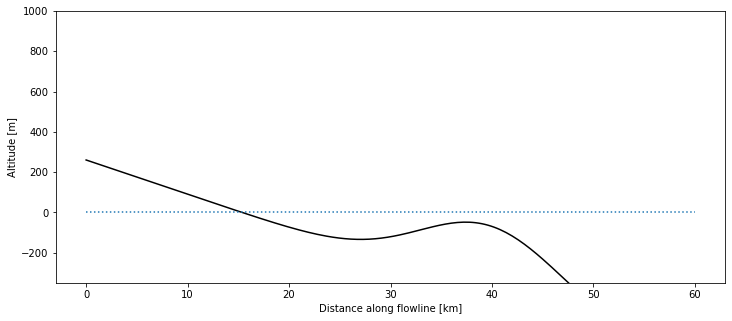

In [8]:
bu_fl = chakra.bu_tidewater_bed()[0]

xc = bu_fl.dis_on_line * bu_fl.dx_meter / 1000
f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(xc, bu_fl.bed_h, color='k',label='bed_h')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.ylim(-350, 1000); plt.ylabel('Altitude [m]'); plt.xlabel('Distance along flowline [km]');


In [9]:
dir(bu_fl)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_attrs_to_dataset',
 '_compute_point_lls',
 '_point_lats',
 '_point_lons',
 '_surface_h',
 '_thick',
 '_vol_below_level',
 '_widths',
 'apparent_mb',
 'area_km2',
 'area_m2',
 'bed_h',
 'bin_area_m2',
 'calving_bucket_m3',
 'dis_on_line',
 'dx',
 'dx_meter',
 'flows_to',
 'flows_to_indice',
 'flows_to_point',
 'flux',
 'flux_needs_correction',
 'geometrical_widths',
 'has_ice',
 'head',
 'inflow_indices',
 'inflow_points',
 'inflows',
 'is_rectangular',
 'is_trapezoid',
 'length_m',
 'line',
 'map_dx',
 'map_trafo',
 'mu_star',
 'mu_star_is_valid',
 'normals',
 'nx',
 'order',
 'orig_head',
 'point_lats',
 'point_lon

In [10]:
xc

array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ,
        3.3,  3.6,  3.9,  4.2,  4.5,  4.8,  5.1,  5.4,  5.7,  6. ,  6.3,
        6.6,  6.9,  7.2,  7.5,  7.8,  8.1,  8.4,  8.7,  9. ,  9.3,  9.6,
        9.9, 10.2, 10.5, 10.8, 11.1, 11.4, 11.7, 12. , 12.3, 12.6, 12.9,
       13.2, 13.5, 13.8, 14.1, 14.4, 14.7, 15. , 15.3, 15.6, 15.9, 16.2,
       16.5, 16.8, 17.1, 17.4, 17.7, 18. , 18.3, 18.6, 18.9, 19.2, 19.5,
       19.8, 20.1, 20.4, 20.7, 21. , 21.3, 21.6, 21.9, 22.2, 22.5, 22.8,
       23.1, 23.4, 23.7, 24. , 24.3, 24.6, 24.9, 25.2, 25.5, 25.8, 26.1,
       26.4, 26.7, 27. , 27.3, 27.6, 27.9, 28.2, 28.5, 28.8, 29.1, 29.4,
       29.7, 30. , 30.3, 30.6, 30.9, 31.2, 31.5, 31.8, 32.1, 32.4, 32.7,
       33. , 33.3, 33.6, 33.9, 34.2, 34.5, 34.8, 35.1, 35.4, 35.7, 36. ,
       36.3, 36.6, 36.9, 37.2, 37.5, 37.8, 38.1, 38.4, 38.7, 39. , 39.3,
       39.6, 39.9, 40.2, 40.5, 40.8, 41.1, 41.4, 41.7, 42. , 42.3, 42.6,
       42.9, 43.2, 43.5, 43.8, 44.1, 44.4, 44.7, 45

In [11]:
xc[[0, -1]]

array([ 0., 60.])

#### Put a k-calving profile on top of this and check what viscoplastic calving rates we'd get

In [12]:
from oggm.core.flowline import FluxBasedModel
from oggm.tests.funcs import bu_tidewater_bed

mb_model = ScalarMassBalance()

model = FluxBasedModel(bu_tidewater_bed()[0], mb_model=mb_model,
                       is_tidewater=True, 
                       calving_use_limiter=True,  # default is True
                       flux_gate=0.06,  # default is 0
                       calving_k=0.2,  # default is 2.4
                       do_kcalving=True
                      )
# long enough to reach approx. equilibrium 
ds = model.run_until_and_store(7000)
df_diag = model.get_diagnostics()

In [13]:
ds.volume_m3.values[-1]*1e-9

#(ds.volume_m3*1e-9).plot

4.867915341373602

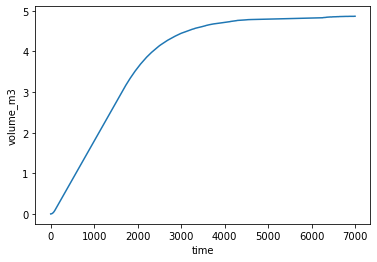

In [14]:
(ds.volume_m3*1e-9).plot()

In [15]:
ds.values()

ValuesView(<xarray.Dataset>
Dimensions:           (time: 7001)
Coordinates:
  * time              (time) float64 0.0 1.0 2.0 ... 6.998e+03 6.999e+03 7e+03
    hydro_year        (time) int64 0 1 2 3 4 5 ... 6995 6996 6997 6998 6999 7000
    hydro_month       (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    calendar_year     (time) int64 -1 0 1 2 3 4 ... 6995 6996 6997 6998 6999
    calendar_month    (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
Data variables:
    volume_m3         (time) float64 0.0 8.672e+03 ... 4.868e+09 4.868e+09
    volume_bsl_m3     (time) float64 0.0 0.0 0.0 ... 1.74e+08 1.74e+08 1.739e+08
    volume_bwl_m3     (time) float64 0.0 0.0 0.0 ... 1.74e+08 1.74e+08 1.739e+08
    area_m2           (time) float64 0.0 5.4e+05 5.4e+05 ... 1.296e+07 1.296e+07
    length_m          (time) float64 0.0 900.0 900.0 ... 2.16e+04 2.16e+04
    calving_m3        (time) float64 0.0 0.0 0.0 ... 8.281e+09 8.283e+09
    calving_rate_myr  (time) float64 0.0 0.

In [16]:
cfg.PARAMS['calving_k']

0.6

In [17]:
df_diag

,surface_h,bed_h,ice_thick,section_width,section_area,slope,ice_flux,ice_velocity,surface_ice_velocity,shape_fac,tributary_flux
distance_along_flowline,,,,,,,,,,,
0.0,711.429284,260.000039,451.429245,600.0,270857.546897,0.010051,0.059998,1.108677e-07,1.385846e-07,1.0,0.0
300.0,705.398735,254.900050,450.498685,600.0,270299.211074,0.020137,0.059995,2.219611e-07,2.774514e-07,1.0,0.0
600.0,699.347265,249.800063,449.547202,600.0,269728.320923,0.020207,0.059992,2.224187e-07,2.780234e-07,1.0,0.0
900.0,693.274282,244.700080,448.574201,600.0,269144.520831,0.020280,0.059988,2.228885e-07,2.786106e-07,1.0,0.0
1200.0,687.179171,239.600101,447.579069,600.0,268547.441660,0.020355,0.059985,2.233710e-07,2.792137e-07,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
58800.0,-729.388310,-729.388310,0.000000,600.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.0,0.0
59100.0,-735.585804,-735.585804,0.000000,600.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.0,0.0
59400.0,-741.679976,-741.679976,0.000000,600.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.0,0.0


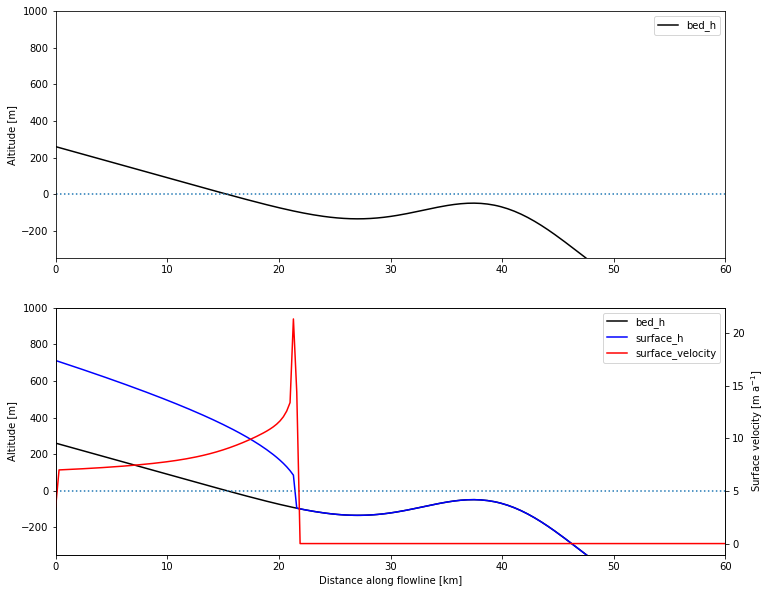

In [18]:
#df_diag.ice_velocity.plot()

#xc = bu_fl.dis_on_line * bu_fl.dx_meter / 1000
# the Bu-bed in SERMeq
plt.figure(1,figsize=(12, 10))
plt.subplot(2,1,1)
lns1,=plt.plot(xc, bu_fl.bed_h, color='k',label='bed_h')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.xlim(0, 60);plt.ylim(-350, 1000); plt.ylabel('Altitude [m]')
plt.legend()
# the k-calving result
ax1=plt.subplot(2,1,2)
lns2,=ax1.plot(xc, df_diag.bed_h, color='k',label='bed_h')
lns3,=ax1.plot(xc, df_diag.surface_h, color='b',label='surface_h')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.xlim(0, 60);plt.ylim(-350, 1000); plt.ylabel('Altitude [m]');plt.xlabel('Distance along flowline [km]')
ax2=ax1.twinx()
lns4,=ax2.plot(xc, df_diag.ice_velocity*31536000, color='r',label='surface_velocity')
plt.ylabel('Surface velocity [m a$^{-1}$]')
legend_profile=plt.legend(handles=[lns2,lns3,lns4],loc='upper right')

#save the figure
plt.savefig('/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/Results/Tests_on_K_calving/Idealized_profile_with volotcity.tif',dpi=600,bbox_inches='tight')
plt.savefig('/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/Results/Tests_on_K_calving/Idealized_profile_with volotcity.png',dpi=600,bbox_inches='tight')

In [19]:
np.argwhere(df_diag.surface_h.values>0)[-1]

array([71])

In [20]:
# scaled_x = 1e-3 * (df_diag.index.values)
#
# fig, ax = plt.subplots(1,1, figsize=(12,5))
# # df_diag.surface_h.plot(ax=ax, color='Gainsboro')
# # df_diag.bed_h.plot(ax=ax, color='k')
# ax.plot(scaled_x, df_diag.surface_h, color='Gainsboro')
# ax.plot(scaled_x, df_diag.bed_h, color='k')
# ax.axhline(0, color='C0', linestyle=':')
# plt.ylim(-350, 1000); plt.ylabel('Altitude [m]'); plt.xlabel('Distance along flowline [km]');

In [21]:
model.calving_rate_myr

18.299620160841567

Okay, this clean test case has a sensible calving rate of 18 m/yr, consistent with what's shown in the Oerlemans-Nick k-calving tutorial on the OGGM site.

In [22]:
surface_profile = df_diag.surface_h
bed_profile = df_diag.bed_h
x = df_diag.index
model_U = df_diag.ice_velocity * cfg.SEC_IN_YEAR ## convert ice velocity to m/a

In [23]:
type(x)
print(x[1])
type(surface_profile)

300.0


pandas.core.series.Series

In [24]:
max(model_U)

21.34959429412458

Okay, the maximum ice velocity is 21 m/a.  This is pretty slow.  Let's see how this goes.

In [25]:
## Find index of the terminus
term_index = int(np.argwhere(surface_profile.values>0)[-1])
print(term_index)
input_profile = (x.values[:term_index+1], ## slice up to index+1 to include the last nonzero value
                 surface_profile.values[:term_index+1],
                 bed_profile.values[:term_index+1])
input_velocity = model_U.values[:term_index+1]

71


In [26]:
no_mb.get_annual_mb(heights=surface_profile.values)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
testval = fa_from_velocity(profile=input_profile, model_velocity=input_velocity, terminus_mb=0, verbose=False,
                    tau0=150e3, yield_type='constant', mu=0.01)

In [28]:
testval

-89.2401778542391

Okay, we got a value that seems reasonable!  This is a pretty high ablation rate given the flow speed of the glacier.  Let's explore a bit.

## Test 1: the effect of yield strength

In [29]:
ty_tests = np.linspace(50e3, 500e3, num=50)
fa_results = [fa_from_velocity(profile=input_profile, model_velocity=input_velocity, terminus_mb=0, verbose=False,
                    tau0=ty, yield_type='constant', mu=0.01,trim_profile=1) for ty in ty_tests]

[Text(0.5, 0, 'Yield strength [kPa]'), Text(0, 0.5, 'Frontal ablation rate')]

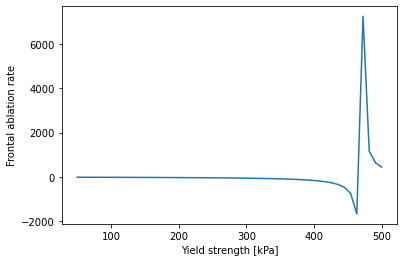

In [30]:
fig, ax = plt.subplots()
ax.plot(1e-3*ty_tests, fa_results)
ax.set(xlabel='Yield strength [kPa]',
       ylabel='Frontal ablation rate')

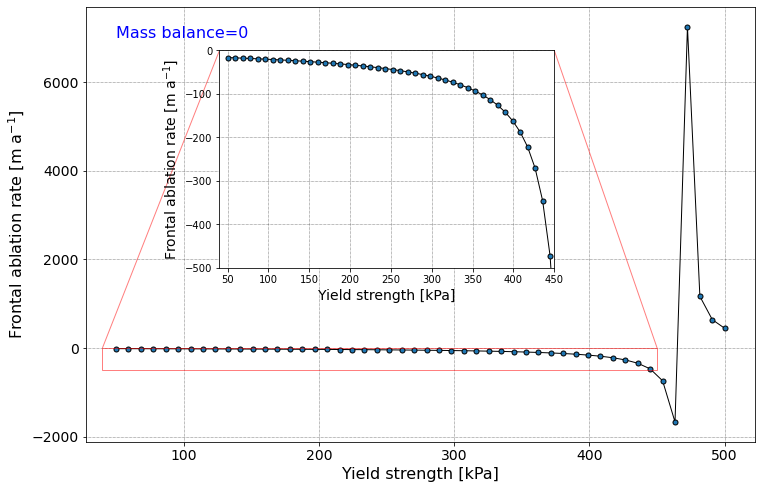

In [31]:
# get the zoom in part
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(1e-3*ty_tests, fa_results,color='k', linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='C0')
plt.xlabel('Yield strength [kPa]',fontsize=16)
plt.ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)
plt.grid(color = 'k', linestyle = ':', linewidth = 0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(50,7000,'Mass balance=0',fontsize=16,color='b')
#ax.spines["top"].set_linewidth(2)
ax.spines["top"].set_color('k')
ax.spines["bottom"].set_color('k')
ax.spines["left"].set_color('k')
ax.spines["right"].set_color('k')

# insert the subplot
axins = ax.inset_axes((0.2,0.4, 0.5, 0.5))
axins.plot(1e-3*ty_tests, fa_results,color='k', linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='C0')
axins.grid(color = 'k', linestyle = ':', linewidth = 0.5)
axins.spines["top"].set_color('k')
axins.spines["bottom"].set_color('k')
axins.spines["left"].set_color('k')
axins.spines["right"].set_color('k')

# set the axis limit of the subregion
xlim0 = 40;xlim1 = 450; ylim0 = -500; ylim1 = 0;
axins.set_xlim(xlim0, xlim1)
axins.set_ylim(ylim0, ylim1)

axins.set_xlabel('Yield strength [kPa]',fontsize=14)
axins.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=14)
# set the connection line between the main and the subregion
ax.indicate_inset_zoom(axins, edgecolor="r")

# save the figure

plt.savefig('/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/Results/Tests_on_Sermeq_Bubed/Yeild strength on Fa.tif',dpi=600,bbox_inches='tight')
plt.savefig('/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/Results/Tests_on_Sermeq_Bubed/Yeild strength on Fa.png',dpi=600,bbox_inches='tight')

In [32]:
t=[]
for ty in ty_tests[0:3]:
    t.append(fa_from_velocity(profile=input_profile, model_velocity=input_velocity, terminus_mb=0, verbose=True,
                    tau0=ty, yield_type='constant', mu=0.01, trim_profile=1))

For inspection on debugging - all should be DIMENSIONAL (m/a):
se_terminus=109.61657275553068
bed_terminus=-87.53185359677735
Thicknesses: Hterm 197.14842635230804, Hadj 0.0
Hy_terminus=103.31787460797432
U_terminus=13.398792129010449
dx_term=300.0
Checking dLdt: terminus_mb = 0. 
 H dUdx = 0.5289890790607029. 
 U dHdx = 8.805169277520337.
Denom: dHydx = 0.3443929153599144 
 dHdx = 0.6571614211743602
Viscoplastic dLdt=29.84366450923501
For inspection on debugging - all should be DIMENSIONAL (m/a):
se_terminus=109.61657275553068
bed_terminus=-87.53185359677735
Thicknesses: Hterm 197.14842635230804, Hadj 0.0
Hy_terminus=105.36611311502224
U_terminus=13.398792129010449
dx_term=300.0
Checking dLdt: terminus_mb = 0. 
 H dUdx = 0.5289890790607029. 
 U dHdx = 8.805169277520337.
Denom: dHydx = 0.35122037705007414 
 dHdx = 0.6571614211743602
Viscoplastic dLdt=30.509663661829936
For inspection on debugging - all should be DIMENSIONAL (m/a):
se_terminus=109.61657275553068
bed_terminus=-87.5318535

In [33]:
print(ty_tests[0:3]/1000)
print(t)


[50.         59.18367347 68.36734694]
[-16.44487238022456, -17.110871532819488, -17.80727395160934]


## Test 2: the effect of mass balance on the terminus (point?)

In [34]:
mb_tests = np.linspace(-200, 200, num=200)
fa_results_mb = [fa_from_velocity(profile=input_profile, model_velocity=input_velocity, terminus_mb=mb, verbose=False,
                    tau0=150e3, yield_type='constant', mu=0.01, trim_profile=1) for mb in mb_tests]

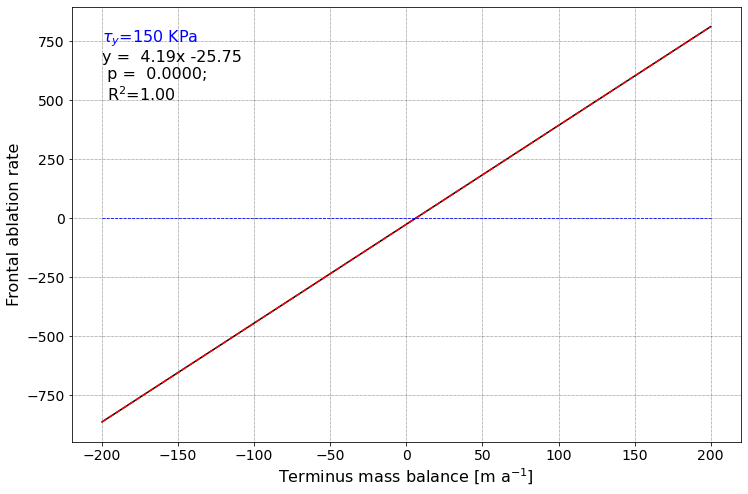

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

#k_mb,b_mb=np.polyfit(mb_tests, fa_results_mb,1)
fa_results_mb_LF=stats.linregress(mb_tests, fa_results_mb)
k_mb=fa_results_mb_LF.slope
b_mb=fa_results_mb_LF.intercept
r2_mb=(fa_results_mb_LF.rvalue)**2
p_mb=fa_results_mb_LF.pvalue
ax.plot(mb_tests, fa_results_mb,'k',mb_tests, k_mb*mb_tests+b_mb,'--r')
ax.plot([min(mb_tests),max(mb_tests)],[0,0],'--b',linewidth=0.8)
#add fitted regression equation to plot
plt.text(-200, 500, 'y = '  + ' {:.2f}'.format(k_mb) + 'x '+ '{:.2f}'.format(b_mb) +
         '\n p = ' +' {:.4f}'.format(p_mb) + ';'+ '\n R$^{2}$=' + '{:.2f}'.format(r2_mb),size=16)
#plt.text(-200, 450, 'p = ' +' {:.2f}'.format(p_mb) + ';'+ '\n R$^{2}$=' + '{:.2f}'.format(r2_mb), size=16)
plt.text(-200,750, r'$\tau_y$=150 KPa',fontsize=16,color='b')
#
plt.xlabel('Terminus mass balance [m a$^{-1}$]',fontsize=16)
plt.ylabel('Frontal ablation rate',fontsize=16)
plt.grid(color = 'k', linestyle = ':', linewidth = 0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.spines["top"].set_color('k')
ax.spines["bottom"].set_color('k')
ax.spines["left"].set_color('k')
ax.spines["right"].set_color('k')
# save the figure
plt.savefig('/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/Results/Tests_on_Sermeq_Bubed/Massbalance on Fa.tif',dpi=600,bbox_inches='tight')
plt.savefig('/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/Results/Tests_on_Sermeq_Bubed/Massbalance on Fa.png',dpi=600,bbox_inches='tight')


fig, (ax1, ax2) = plt.subplots(1,2,sharey=True)
ax1.plot(1e-3*ty_tests, fa_results)
ax1.set(xlabel='Yield strength [kPa], mb=0',
       ylabel='Frontal ablation rate')
ax2.plot(mb_tests, fa_results_mb)
ax2.set(xlabel=r'Terminus mass balance [m/a], $\tau_y$=150 KPa')

## Test 3 : the effect of the velocity
We know our glacier is moving slowly.  What does the frontal ablation rate look like if we scale up the velocity?


In [36]:
v_scalings = np.linspace(1,50,num=50)
fa_results_v = [fa_from_velocity(profile=input_profile, model_velocity=v*np.asarray(input_velocity), terminus_mb=0, verbose=False,
                    tau0=150e3, yield_type='constant', mu=0.01,trim_profile=1) for v in v_scalings]

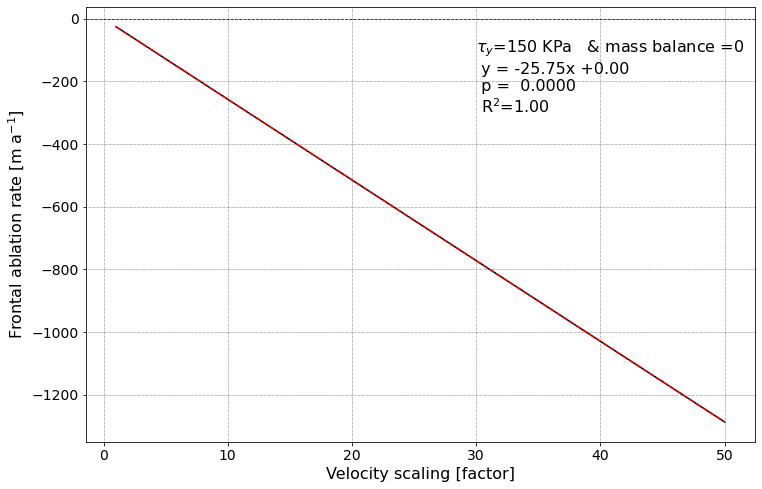

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
#k_v,b_v=np.polyfit(v_scalings, fa_results_v,1)
fa_results_v_LF=stats.linregress(v_scalings, fa_results_v)
k_v=fa_results_v_LF.slope
b_v=fa_results_v_LF.intercept
r2_v=(fa_results_v_LF.rvalue)**2
p_v=fa_results_v_LF.pvalue
ax.plot(v_scalings, fa_results_v,'k',v_scalings, k_v*v_scalings+b_v,'--r')
ax.axhline(0, color='b', ls='--',linewidth=0.8)
#add fitted regression equation to plot
# plt.text(30, -200, 'y = '  + ' {:.2f}'.format(k_v) + 'x '+ '+'+'{:.2f}'.format(b_v)+
#          \n r'$\tau_y$=150 KPa   & mass balance =0'+'\n p = ' +' {:.4f}'.format(p_mb) +
#             ';'+ '\n R$^{2}$=' + '{:.2f}'.format(r2_mb), size=16)
plt.text(30, -300, r'$\tau_y$=150 KPa   & mass balance =0'+'\n y = '  +
         '{:.2f}'.format(k_v) + 'x '+ '+'+'{:.2f}'.format(b_v)+'\n p = ' +' {:.4f}'.format(p_v) +
         '\n R$^{2}$=' + '{:.2f}'.format(r2_v),fontsize=16,color='k')
#
plt.xlabel('Velocity scaling [factor]',fontsize=16)
plt.ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)
plt.grid(color = 'k', linestyle = ':', linewidth = 0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.spines["top"].set_color('k')
ax.spines["bottom"].set_color('k')
ax.spines["left"].set_color('k')
ax.spines["right"].set_color('k')
# save the figure
plt.savefig('/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/Results/Tests_on_Sermeq_Bubed/Velocity scaling on Fa.tif',dpi=600,bbox_inches='tight')
plt.savefig('/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/Results/Tests_on_Sermeq_Bubed/Velocity scaling Fa.png',dpi=600,bbox_inches='tight')

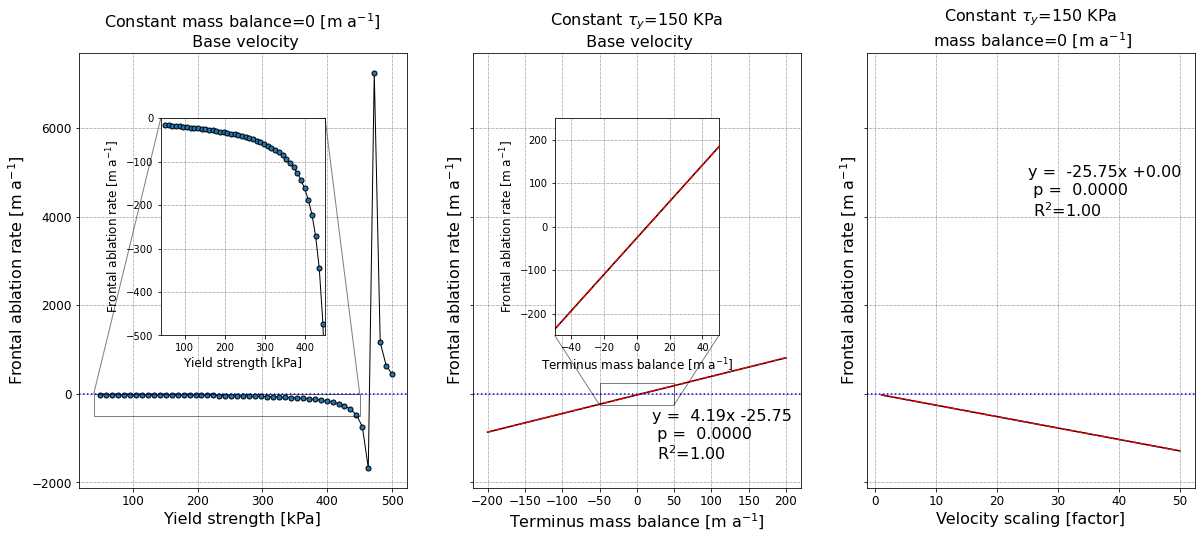

In [38]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3,sharey=True, figsize=(20,8))

# yeild strength

ax1.plot(1e-3*ty_tests, fa_results,color='k', linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='C0')
ax1.set_title("Constant mass balance=0 [m a$^{-1}$] \n Base velocity",fontsize=16)
ax1.set_xlabel('Yield strength [kPa]',fontsize=16)
ax1.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)

# insert the subplot
axins = ax1.inset_axes((0.25,0.35, 0.5, 0.5))
axins.plot(1e-3*ty_tests, fa_results,color='k', linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='C0')
axins.grid(color = 'k', linestyle = ':', linewidth = 0.5)
axins.spines["top"].set_color('k')
axins.spines["bottom"].set_color('k')
axins.spines["left"].set_color('k')
axins.spines["right"].set_color('k')

# set the axis limit of the subregion
xlim0 = 40;xlim1 = 450; ylim0 = -500; ylim1 = 0;
axins.set_xlim(xlim0, xlim1)
axins.set_ylim(ylim0, ylim1)
axins.set_xlabel('Yield strength [kPa]',fontsize=12)
axins.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=12)
# set the connection line between the main and the subregion
ax1.indicate_inset_zoom(axins, edgecolor="k")

# subplot2
ax2.plot(mb_tests, fa_results_mb,'k',mb_tests, k_mb*mb_tests+b_mb,'--r')
ax2.set_title(r'Constant $\tau_y$=150 KPa' + '\n Base velocity',fontsize=16)

#add fitted regression equation to plot
ax2.text(20, -1500, 'y = '  + ' {:.2f}'.format(k_mb) + 'x '+ '{:.2f}'.format(b_mb)+
         '\n p = ' +' {:.4f}'.format(p_mb) +
         '\n R$^{2}$=' + '{:.2f}'.format(r2_mb), fontsize=16)
ax2.set_xlabel('Terminus mass balance [m a$^{-1}$]',fontsize=16)
ax2.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)
# insert the subplot
axins2 = ax2.inset_axes((0.25,0.35, 0.5, 0.5))
axins2.plot(mb_tests, fa_results_mb,'k',mb_tests, k_mb*mb_tests+b_mb,'--r')
axins2.grid(color = 'k', linestyle = ':', linewidth = 0.5)
axins2.spines["top"].set_color('k')
axins2.spines["bottom"].set_color('k')
axins2.spines["left"].set_color('k')
axins2.spines["right"].set_color('k')

# set the axis limit of the subregion
xlim0_2 = -50;xlim1_2 = 50; ylim0_2= -250; ylim1_2= 250;
axins2.set_xlim(xlim0_2, xlim1_2)
axins2.set_ylim(ylim0_2, ylim1_2)
axins2.set_xlabel('Terminus mass balance [m a$^{-1}$]',fontsize=12)
axins2.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=12)
# set the connection line between the main and the subregion
ax2.indicate_inset_zoom(axins2, edgecolor="k")

#subplot3

ax3.plot(v_scalings, fa_results_v,'k',v_scalings, k_v*v_scalings+b_v,'--r')
ax3.set_title(r'Constant $\tau_y$=150 KPa' + '\n mass balance=0 [m a$^{-1}$]',fontsize=16)

#add fitted regression equation to plot
ax3.text(25, 4000, 'y = '  + ' {:.2f}'.format(k_v) + 'x '+ '+'+'{:.2f}'.format(b_v)+
              '\n p = ' +' {:.4f}'.format(p_v) +
         '\n R$^{2}$=' + '{:.2f}'.format(r2_v), fontsize=16)
ax3.set_xlabel('Velocity scaling [factor]',fontsize=16)
ax3.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)

# set the figure properites
for ax in (ax1,ax2,ax3):
    #ax.legend(loc='upper left')
    ax.spines["top"].set_color('k')
    ax.spines["bottom"].set_color('k')
    ax.spines["left"].set_color('k')
    ax.spines["right"].set_color('k')
    ax.grid(True,color = 'k', linestyle = ':', linewidth = 0.5)
    ax.axhline(0, color='b', ls=':')
    ax.fontsize=16
    ax.tick_params(labelsize=12)



# save the figure

plt.savefig('/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/Results/Tests_on_Sermeq_Bubed/YieldS_MB_Velodity on Fa.tif',dpi=600,bbox_inches='tight')
plt.savefig('/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/Results/Tests_on_Sermeq_Bubed/YieldS_MB_Velodity on Fa.png',dpi=600,bbox_inches='tight')


This case appears to have an instability around $\tau_y$ in (460,470) kPa.  We can investigate that later, but for now let's just trim it so we can see everything else more clearly.

## Test on Columbia Glacier

In [169]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import time, os

from oggm.core.massbalance import ScalarMassBalance
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.tests.funcs import bu_tidewater_bed
from oggm.core.flowline import FluxBasedModel

2023-05-30 20:48:13: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-05-30 20:48:13: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


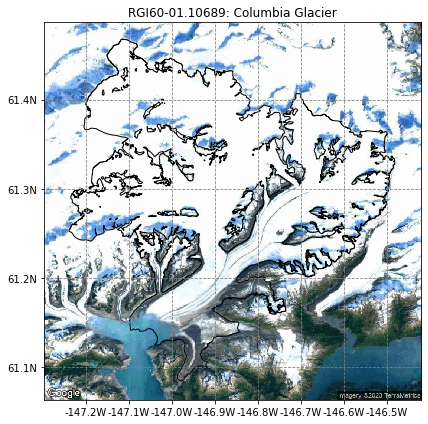

In [173]:
rgi_id = 'RGI60-01.10689'

cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-Calving', reset=True)
cp_dir = os.path.join(cfg.PATHS['working_dir'], 'calving')
# Download from the "OGGM shop"
gdir_woc = workflow.init_glacier_directories([rgi_id], from_prepro_level=3, prepro_border=80)[0]
tasks.init_present_time_glacier(gdir_woc)
# create the result folder
Figpath='/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/Results/Steadystate_Tests_on_Sermeq_Bubed'
Figpath_Folder_tif_path=Figpath+'/Tif/'+rgi_id+'/'
Figpath_Folder_png_path=Figpath+'/Png/'+rgi_id+'/'
Figpath_Folder_tif=utils.mkdir(Figpath_Folder_tif_path,reset=True)
Figpath_Folder_png=utils.mkdir(Figpath_Folder_png_path,reset=True)
# get the glacier topography
graphics.plot_googlemap(gdir_woc, figsize=(6,6));
# save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Topography'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Topography'+'.png',dpi=600,bbox_inches='tight')

In [159]:
# # Calving params - default used to be 2.4, we changed it to 0.6
# cfg.PARAMS['inversion_calving_k'] = 0.6
# cfg.PARAMS['calving_k'] = 0.6
#
# # These are switched off per default
# cfg.PARAMS['use_kcalving_for_inversion'] = True
# cfg.PARAMS['use_kcalving_for_run'] = True
#
# # Reference data for the recalibration of the mass-balance
# #ref_tstars_url = 'https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/oggm_v1.4/RGIV62/CRU/centerlines/qc3/pcp2.5'
# #workflow.download_ref_tstars(base_url=ref_tstars_url)
#
# # Back to regular OGGM defaults
# cfg.PARAMS['cfl_number'] = 0.02
#
# # Make a copy of our glacier directory where we will make the experiments
# # Beware! If you use `reset=True` in `utils.mkdir`, ALL DATA in this folder will be deleted! Use with caution!
# utils.mkdir(cp_dir, reset=True)
# gdir_wc = utils.copy_to_basedir(gdir_woc, base_dir=cp_dir, setup='all')
# # Find out the calving values


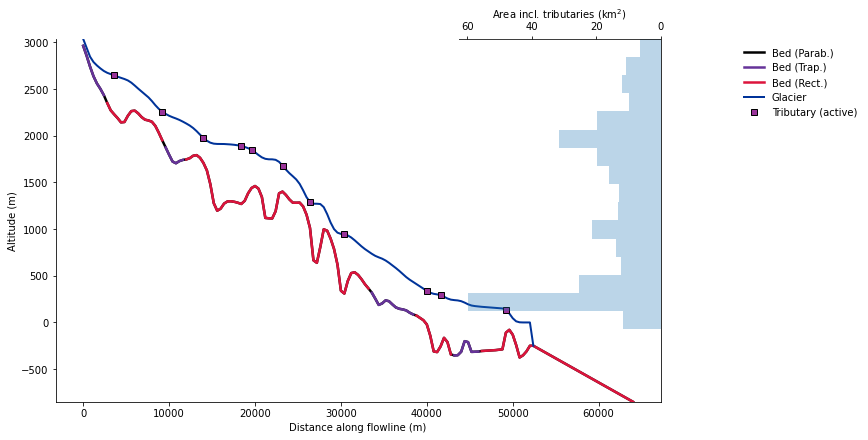

In [174]:
# get the glacier profile along the flowline(main centerline) and area histogram
bu_fl = gdir_woc.read_pickle('model_flowlines')[-1]
graphics.plot_modeloutput_section([bu_fl])
#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Glacier_profile_AreaHist'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Glacier_profile_AreaHist'+'.png',dpi=600,bbox_inches='tight')

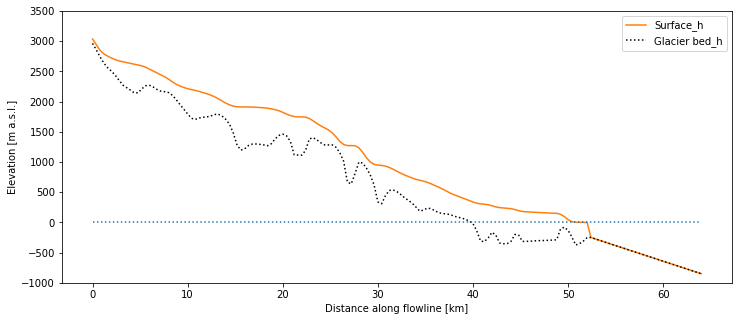

In [175]:
xc = bu_fl.dis_on_line * bu_fl.map_dx / 1000
f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(xc, bu_fl.surface_h, '-', color='C1', label='Surface_h')
ax.plot(xc, bu_fl.bed_h, ':', color='k', label='Glacier bed_h')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.ylim(-1000, 3500); plt.ylabel('Elevation [m a.s.l.]'); plt.xlabel('Distance along flowline [km]');
plt.legend();
#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Glacier_profile'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Glacier_profile'+'.png',dpi=600,bbox_inches='tight')

## Put a k-calving profile on top of this and check what viscoplastic calving rates we'd get

In [178]:
from oggm.core.flowline import FluxBasedModel
from oggm.tests.funcs import bu_tidewater_bed

mb_model = ScalarMassBalance()

model = FluxBasedModel(bu_fl, mb_model=mb_model,
                       is_tidewater=True, 
                       calving_use_limiter=True,  # default is True
                       flux_gate=0.06,  # default is 0
                       calving_k=0.2,  # default is 2.4
                       do_kcalving=True
                      )
# long enough to reach approx. equilibrium 
ds = model.run_until_and_store(6000)
df_diag = model.get_diagnostics()


In [46]:
cfg.PARAMS['calving_k']

0.6

In [179]:
df_diag

,surface_h,bed_h,ice_thick,section_width,section_area,slope,ice_flux,ice_velocity,surface_ice_velocity,shape_fac,tributary_flux
distance_along_flowline,,,,,,,,,,,
0.0,3025.613013,2962.760140,62.852873,5301.555703,329267.524595,0.138908,0.06,9.499384e-08,1.187423e-07,1.0,0.0
400.0,2914.486374,2856.278730,58.207644,5252.582949,302352.347332,0.277684,0.06,1.930348e-07,2.412935e-07,1.0,0.0
800.0,2803.465826,2739.566168,63.899658,4909.573123,309636.876403,0.246482,0.06,1.877962e-07,2.347452e-07,1.0,0.0
1200.0,2717.301083,2636.753238,80.547845,4535.636866,358847.821658,0.187555,0.06,1.681133e-07,2.101417e-07,1.0,0.0
1600.0,2653.422152,2559.208786,94.213366,4412.787835,406867.436025,0.150553,0.06,1.525532e-07,1.906915e-07,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
62400.0,-767.038223,-767.038223,0.000000,3849.020124,0.000000,0.000000,0.00,0.000000e+00,0.000000e+00,1.0,0.0
62800.0,-787.727878,-787.727878,0.000000,3849.020124,0.000000,0.000000,0.00,0.000000e+00,0.000000e+00,1.0,0.0
63200.0,-808.417533,-808.417533,0.000000,3849.020124,0.000000,0.000000,0.00,0.000000e+00,0.000000e+00,1.0,0.0


<AxesSubplot:xlabel='distance_along_flowline'>

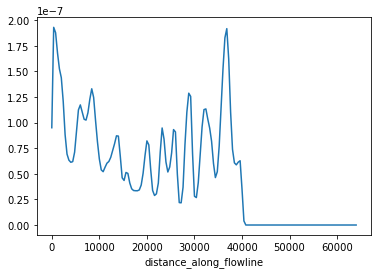

In [188]:
df_diag.ice_velocity.plot()

In [189]:
cfg.SEC_IN_YEAR

31536000

In [190]:
max(df_diag.ice_velocity * cfg.SEC_IN_YEAR)

6.087545032799393

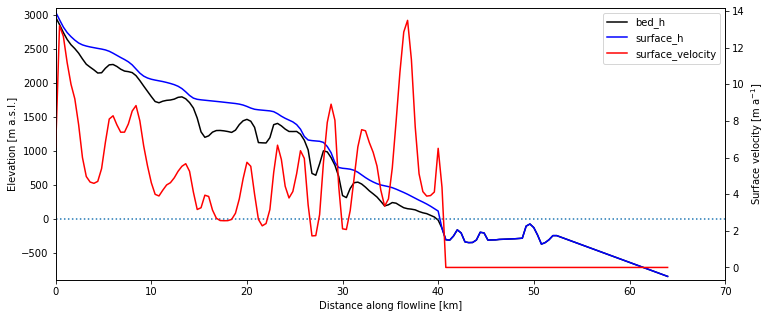

In [199]:
plt.figure(1,figsize=(12, 5))
ax=plt.subplot(1,1,1)
xlim0=0;xlim1=(max(xc)//10+1)*10
ylim0=(min(df_diag.bed_h)//100)*100;ylim1=(max(df_diag.surface_h)//100+1)*100
lns1,=ax.plot(xc, df_diag.bed_h, color='k',label='bed_h')
lns2,=ax.plot(xc, df_diag.surface_h, color='b',label='surface_h')
plt.hlines(0, xlim0,xlim1, color='C0', linestyles=':')
plt.xlim(xlim0, xlim1);plt.ylim(ylim0, ylim1); plt.ylabel('Elevation [m a.s.l.]');plt.xlabel('Distance along flowline [km]')
ax2=ax.twinx()
lns3,=ax2.plot(xc, df_diag.ice_velocity*cfg.SEC_IN_YEAR, color='r',label='surface_velocity')
plt.ylabel('Surface velocity [m a$^{-1}$]')
legend_profile=plt.legend(handles=[lns1,lns2,lns3],loc='upper right')
#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Glacier_profile_velocity'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Glacier_profile_velocity'+'.png',dpi=600,bbox_inches='tight')

In [192]:
np.argwhere(df_diag.surface_h.values>0)[-1]


array([100])

In [193]:
# scaled_x = 1e-3 * (df_diag.index.values)
# fig, ax = plt.subplots(1,1, figsize=(12,5))
# # df_diag.surface_h.plot(ax=ax, color='Gainsboro')
# # df_diag.bed_h.plot(ax=ax, color='k')
# ax.plot(scaled_x, df_diag.surface_h, color='Gainsboro')
# ax.plot(scaled_x, df_diag.bed_h, color='k')
# ax.axhline(0, color='C0', linestyle=':')
# plt.ylim(-1000, 3500); plt.ylabel('Altitude [m]'); plt.xlabel('Distance along flowline [km]');

In [194]:
model.calving_rate_myr


4.262698213140698

## Equilibrium states

We create a simple experiment where the surface mass-balance is zero in the entire domain. Ice enters via a flux gate on the left (unit: m3 s−1). We can vary the amount of ice entering the domain via the flux gate. We let the glacier grow until equilibrium with three different flux values:

4.262698213140698
4.262698213140698
4.262698213140697


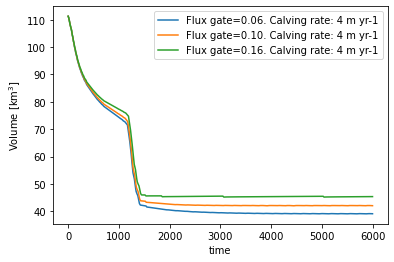

In [198]:
mb_model = ScalarMassBalance()

to_plot = None
keys = []
for flux_gate in [0.06, 0.10, 0.16]:
    model = FluxBasedModel(bu_fl, mb_model=mb_model,
                           is_tidewater=True, 
                           flux_gate=flux_gate,  # default is 0
                           calving_k=0.2,  # default is 2.4
                           do_kcalving=True
                          )
    # long enough to reach approx. equilibrium 
    ds = model.run_until_and_store(6000)
    df_diag = model.get_diagnostics()
    
    if to_plot is None:
        to_plot = df_diag
    
    key = 'Flux gate={:.02f}. Calving rate: {:.0f} m yr-1'.format(flux_gate, model.calving_rate_myr)
    to_plot[key] = df_diag['surface_h']
    keys.append(key)
    print(model.calving_rate_myr)
    # Plot of volume
    (ds.volume_m3 * 1e-9).plot(label=key);
plt.legend(); plt.ylabel('Volume [km$^{3}$]');
to_plot.index = xc
#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Steady_volumechange_ts_Diff_Flux'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Steady_volumechange_ts_Diff_Flux'+'.png',dpi=600,bbox_inches='tight')

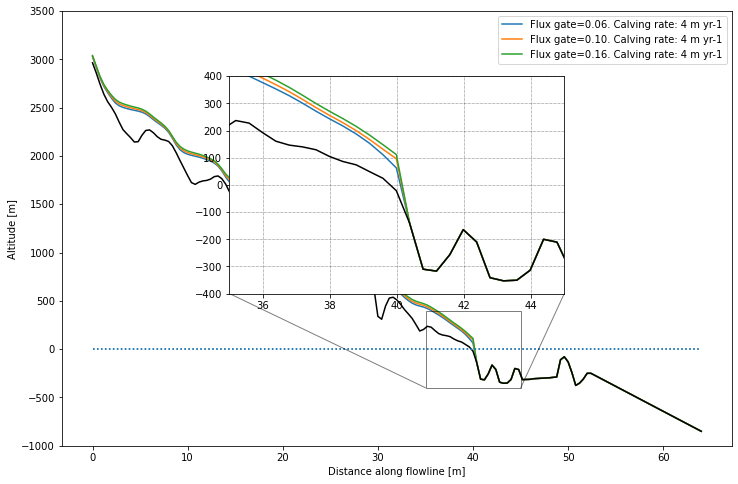

In [207]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
to_plot[keys].plot(ax=ax);
to_plot.bed_h.plot(ax=ax, color='k')
plt.hlines(0, *to_plot.index[[0, -1]], color='C0', linestyles=':')
plt.ylim(-1000, 3500); plt.ylabel('Altitude [m]'); plt.xlabel('Distance along flowline [m]');

axins = ax.inset_axes((0.5,0.35, 0.4, 0.5))
to_plot[keys].plot(ax=axins);
to_plot.bed_h.plot(ax=axins, color='k')
plt.hlines(0, *to_plot.index[[0, -1]], color='C0', linestyles=':')
axins.grid(color = 'k', linestyle = ':', linewidth = 0.5)
axins.spines["top"].set_color('k')
axins.spines["bottom"].set_color('k')
axins.spines["left"].set_color('k')
axins.spines["right"].set_color('k')

# set the axis limit of the subregion
xlim0 = 35;xlim1 = 45; ylim0 = -400; ylim1 = 400;
axins.set_xlim(xlim0, xlim1)
axins.set_ylim(ylim0, ylim1)
axins.legend_=None
#axins.set_xlabel('Yield strength [kPa]',fontsize=12)
#axins.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=12)
# set the connection line between the main and the subregion
ax.indicate_inset_zoom(axins, edgecolor="k")

#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Steady_profile_DiffFlux'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Steady_profile_DiffFlux'+'.png',dpi=600,bbox_inches='tight')

4.262698213140698
4.262698213140698


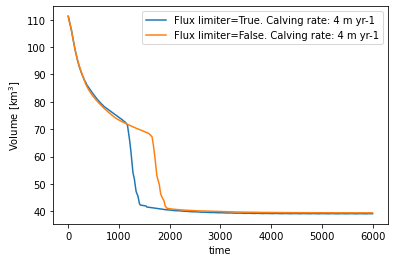

In [208]:
to_plot = None
keys = []
for limiter in [True, False]:
    model = FluxBasedModel(bu_fl, mb_model=mb_model,
                           is_tidewater=True,
                           calving_use_limiter=limiter,  # default is True
                           flux_gate=0.06,  # default is 0
                           calving_k=0.2,# default is 2.4
                           do_kcalving=True
                          )
    # long enough to reach approx. equilibrium
    ds = model.run_until_and_store(6000)
    df_diag = model.get_diagnostics()

    if to_plot is None:
        to_plot = df_diag

    key = 'Flux limiter={}. Calving rate: {:.0f} m yr-1'.format(limiter, model.calving_rate_myr)
    to_plot[key] = df_diag['surface_h']
    keys.append(key)
    print(model.calving_rate_myr)
    # Plot of volume
    (ds.volume_m3 * 1e-9).plot(label=key);
plt.legend(); plt.ylabel('Volume [km$^{3}$]');
#to_plot.index = xc

#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Steady_volumechange_ts_Limiter'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Steady_volumechange_ts_Limiter'+'.png',dpi=600,bbox_inches='tight')


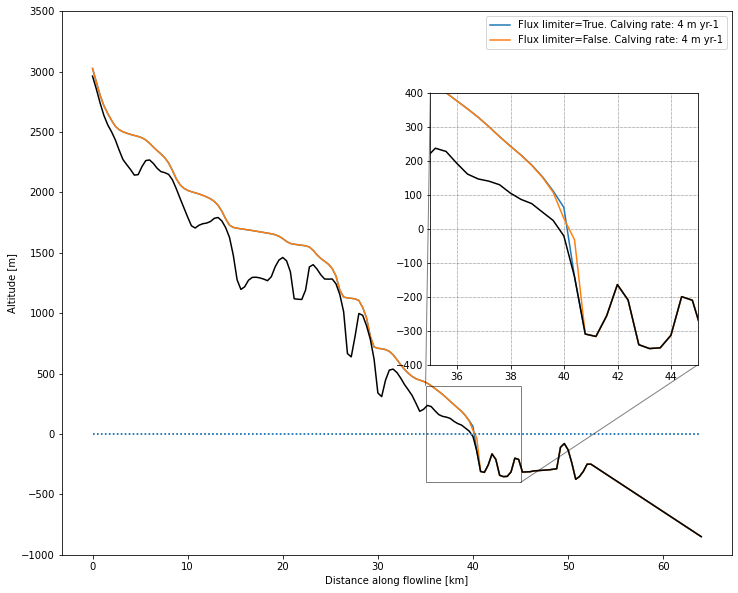

In [212]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
to_plot[keys].plot(ax=ax);
to_plot.bed_h.plot(ax=ax, color='k')
plt.hlines(0, *to_plot.index[[0, -1]], color='C0', linestyles=':')
plt.ylim(-1000, 3500); plt.ylabel('Altitude [m]'); plt.xlabel('Distance along flowline [km]');
#to_plot.index = xc

axins = ax.inset_axes((0.55,0.35, 0.4, 0.5))
to_plot[keys].plot(ax=axins);
to_plot.bed_h.plot(ax=axins, color='k')
plt.hlines(0, *to_plot.index[[0, -1]], color='C0', linestyles=':')
axins.grid(color = 'k', linestyle = ':', linewidth = 0.5)
axins.spines["top"].set_color('k')
axins.spines["bottom"].set_color('k')
axins.spines["left"].set_color('k')
axins.spines["right"].set_color('k')

# set the axis limit of the subregion
xlim0 = 35;xlim1 = 45; ylim0 = -400; ylim1 = 400;
axins.set_xlim(xlim0, xlim1)
axins.set_ylim(ylim0, ylim1)
axins.legend_=None
#axins.set_xlabel('Yield strength [kPa]',fontsize=12)
#axins.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=12)
# set the connection line between the main and the subregion
ax.indicate_inset_zoom(axins, edgecolor="k")

#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Steady_profile_FluxLimiter'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Steady_profile_FluxLimiter'+'.png',dpi=600,bbox_inches='tight')


## Semeq frontal ablation

In [213]:

mb_model = ScalarMassBalance()

model = FluxBasedModel(bu_fl, mb_model=mb_model,
                       is_tidewater=True,
                       calving_use_limiter=True,  # default is True
                       flux_gate=0.06,  # default is 0
                       calving_k=0.2,  # default is 2.4
                       do_kcalving=True
                      )
# long enough to reach approx. equilibrium
ds = model.run_until_and_store(6000)
df_diag = model.get_diagnostics()

surface_profile = df_diag.surface_h
bed_profile = df_diag.bed_h
x = df_diag.index
model_U = df_diag.ice_velocity * cfg.SEC_IN_YEAR ## convert ice velocity to m/a

In [214]:
## Find index of the terminus
term_index = int(np.argwhere(surface_profile.values>0)[-1])

input_profile = (x.values[:term_index+1], ## slice up to index+1 to include the last nonzero value
                 surface_profile.values[:term_index+1],
                 bed_profile.values[:term_index+1])
input_velocity = model_U.values[:term_index+1]
no_mb.get_annual_mb(heights=surface_profile.values[0])
testval = fa_from_velocity(profile=input_profile, model_velocity=input_velocity, terminus_mb=0, verbose=False,
                    tau0=150e3, yield_type='constant', mu=0.01)
testval

0.4198307514078199

In [215]:
term_index

100

33


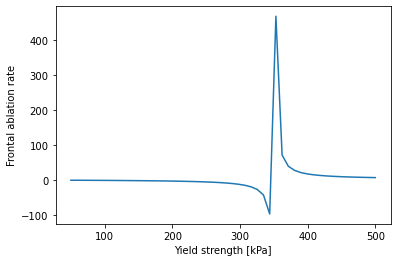

In [216]:
ty_tests = np.linspace(50e3, 500e3, num=50)
fa_results = [fa_from_velocity(profile=input_profile, model_velocity=input_velocity, terminus_mb=0, verbose=False,
                               tau0=ty, yield_type='constant', mu=0.01, trim_profile=1) for ty in ty_tests]
fig, ax = plt.subplots()
ax.plot(1e-3 * ty_tests, fa_results)
ax.set(xlabel='Yield strength [kPa]',
       ylabel='Frontal ablation rate')

## Find index of the terminus
term_Posi_FA_index = int(np.argwhere(np.array(fa_results)>0)[0])
print(term_Posi_FA_index)

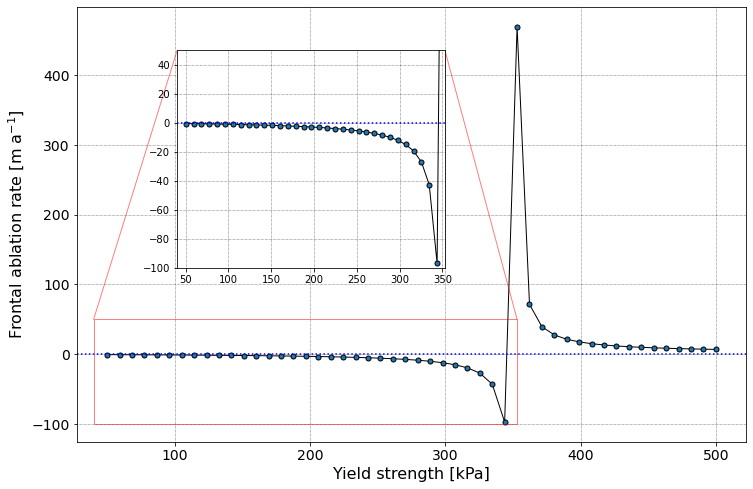

In [249]:
# get the zoom in part
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(1e-3*ty_tests, fa_results,color='k', linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='C0')
plt.xlabel('Yield strength [kPa]',fontsize=16)
plt.ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)
plt.grid(color = 'k', linestyle = ':', linewidth = 0.5)
ax.axhline(0, color='b', ls=':')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.text(50,7000,'Mass balance=0',fontsize=16,color='b')
#ax.spines["top"].set_linewidth(2)
ax.spines["top"].set_color('k')
ax.spines["bottom"].set_color('k')
ax.spines["left"].set_color('k')
ax.spines["right"].set_color('k')

# insert the subplot
axins = ax.inset_axes((0.15,0.4, 0.4, 0.5))
axins.plot(1e-3*ty_tests, fa_results,color='k', linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='C0')
axins.grid(color = 'k', linestyle = ':', linewidth = 0.5)
axins.axhline(0, color='b', ls=':')
axins.spines["top"].set_color('k')
axins.spines["bottom"].set_color('k')
axins.spines["left"].set_color('k')
axins.spines["right"].set_color('k')

# set the axis limit of the subregion
xlim0 = 40;xlim1 =1e-3*ty_tests[term_Posi_FA_index] ; ylim0 = ((min(fa_results))//50)*50; ylim1 = 50;
axins.set_xlim(xlim0, xlim1)
axins.set_ylim(ylim0, ylim1)

# axins.set_xlabel('Yield strength [kPa]',fontsize=14)
# axins.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=14)
# set the connection line between the main and the subregion
ax.indicate_inset_zoom(axins, edgecolor="r")

#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Yeild strength on Fa'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Yeild strength on Fa'+'.png',dpi=600,bbox_inches='tight')

## Test 2: the effect of mass balance on the terminus (point?)

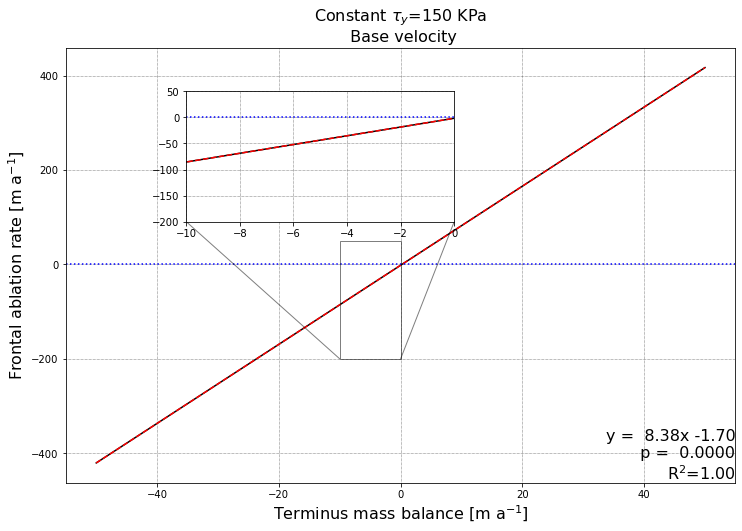

In [268]:

mb_tests = np.linspace(-50, 50, num=200)
fa_results_mb = [fa_from_velocity(profile=input_profile, model_velocity=input_velocity, terminus_mb=mb, verbose=False,
                                  tau0=150e3, yield_type='constant', mu=0.01, trim_profile=1) for mb in mb_tests]
#k_mb,b_mb=np.polyfit(mb_tests, fa_results_mb,1)
fa_results_mb_LF = stats.linregress(mb_tests, fa_results_mb)
k_mb = fa_results_mb_LF.slope
b_mb = fa_results_mb_LF.intercept
r2_mb = (fa_results_mb_LF.rvalue) ** 2
p_mb = fa_results_mb_LF.pvalue
## Find index of the terminus
term_Posi_FA_index_mb = int(np.argwhere(np.array(fa_results_mb)>0)[0])


fig, ax2 = plt.subplots(1, 1, figsize=(12, 8))
# subplot2
ax2.plot(mb_tests, fa_results_mb,'k',mb_tests, k_mb*mb_tests+b_mb,'--r')
plt.grid(color = 'k', linestyle = ':', linewidth = 0.5)
ax2.axhline(0, color='b', ls=':')
ax2.set_title(r'Constant $\tau_y$=150 KPa' + '\n Base velocity',fontsize=16)

#add fitted regression equation to plot
# ax2.text(0, -300, 'y = '  + ' {:.2f}'.format(k_mb) + 'x '+ '{:.2f}'.format(b_mb)+
#          '\n p = ' +' {:.4f}'.format(p_mb) +
#          '\n R$^{2}$=' + '{:.2f}'.format(r2_mb), fontsize=16)

ax2.annotate('y = '  + ' {:.2f}'.format(k_mb) + 'x '+ '{:.2f}'.format(b_mb)+
         '\n p = ' +' {:.4f}'.format(p_mb) +
         '\n R$^{2}$=' + '{:.2f}'.format(r2_mb),
             xy=(1, 0),xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='bottom')
ax2.set_xlabel('Terminus mass balance [m a$^{-1}$]',fontsize=16)
ax2.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)
# insert the subplot
axins2 = ax2.inset_axes((0.18,0.6, 0.4, 0.3))
axins2.plot(mb_tests, fa_results_mb,'k',mb_tests, k_mb*mb_tests+b_mb,'--r')
axins2.grid(color = 'k', linestyle = ':', linewidth = 0.5)
axins2.spines["top"].set_color('k')
axins2.spines["bottom"].set_color('k')
axins2.spines["left"].set_color('k')
axins2.spines["right"].set_color('k')

# set the axis limit of the subregion
xlim0 = -10;xlim1 =1e-3*mb_tests[term_Posi_FA_index_mb] ;ylim0 = -200; ylim1 = 50;
axins2.set_xlim(xlim0, xlim1)
axins2.set_ylim(ylim0, ylim1)

#
# xlim0_2 = -10;xlim1_2 = 1; ylim0_2= -100; ylim1_2= 50;
# axins2.set_xlim(xlim0_2, xlim1_2)
# axins2.set_ylim(ylim0_2, ylim1_2)
# axins2.set_xlabel('Terminus mass balance [m a$^{-1}$]',fontsize=11)
# axins2.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=11)
axins2.axhline(0, color='b', ls=':')
axins2.legend_=None
# set the connection line between the main and the subregion
ax2.indicate_inset_zoom(axins2, edgecolor="k")

#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Massbalance on Fa'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Massbalance on Fa'+'.png',dpi=600,bbox_inches='tight')


## Test 3 : the effect of the velocity
We know our glacier is moving slowly.What does the frontal ablation rate look like if we scale up the velocity?

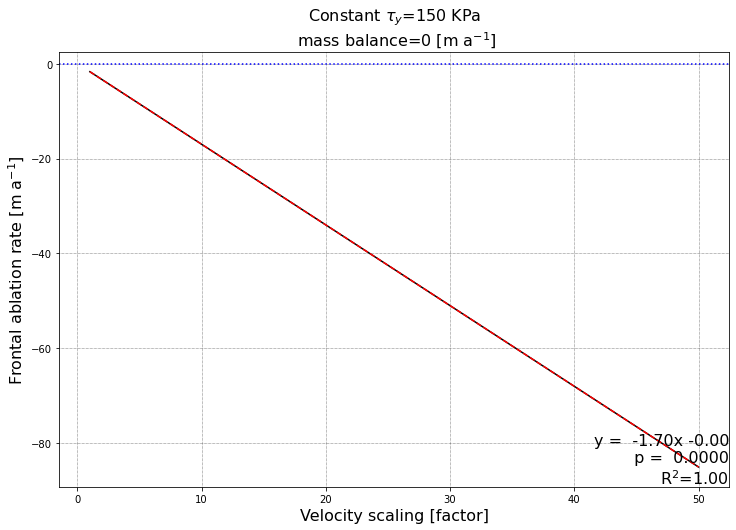

In [253]:
v_scalings = np.linspace(1, 50, num=50)
fa_results_v = [
    fa_from_velocity(profile=input_profile, model_velocity=v * np.asarray(input_velocity), terminus_mb=0, verbose=False,
                     tau0=150e3, yield_type='constant', mu=0.01, trim_profile=1) for v in v_scalings]
#k_v,b_v=np.polyfit(v_scalings, fa_results_v,1)
fa_results_v_LF = stats.linregress(v_scalings, fa_results_v)
k_v = fa_results_v_LF.slope
b_v = fa_results_v_LF.intercept
r2_v = (fa_results_v_LF.rvalue) ** 2
p_v = fa_results_v_LF.pvalue


fig, ax3 = plt.subplots(1, 1, figsize=(12, 8))
ax3.plot(v_scalings, fa_results_v,'k',v_scalings, k_v*v_scalings+b_v,'--r')
ax3.set_title(r'Constant $\tau_y$=150 KPa' + '\n mass balance=0 [m a$^{-1}$]',fontsize=16)
ax3.axhline(0, color='b', ls=':')
ax3.grid(color = 'k', linestyle = ':', linewidth = 0.5)
#add fitted regression equation to plot
ax3.annotate('y = '  + ' {:.2f}'.format(k_v) + 'x '+ '{:.2f}'.format(b_v)+
         '\n p = ' +' {:.4f}'.format(p_v) +
         '\n R$^{2}$=' + '{:.2f}'.format(r2_v),
             xy=(1, 0),xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='bottom')

ax3.set_xlabel('Velocity scaling [factor]',fontsize=16)
ax3.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)

#
# # #save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Velodity scale on Fa'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Velodity scale on Fa'+'.png',dpi=600,bbox_inches='tight')






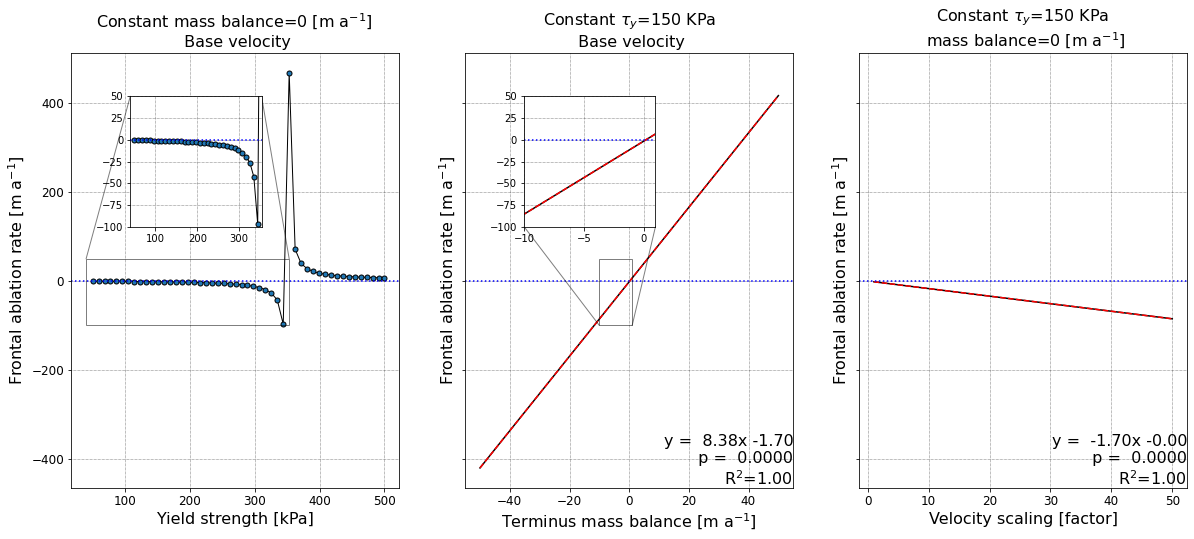

In [270]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3,sharey=True, figsize=(20,8))

# yeild strength

ax1.plot(1e-3*ty_tests, fa_results,color='k', linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='C0')
ax1.set_title("Constant mass balance=0 [m a$^{-1}$] \n Base velocity",fontsize=16)
ax1.set_xlabel('Yield strength [kPa]',fontsize=16)
ax1.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)

# insert the subplot
axins = ax1.inset_axes((0.18,0.6, 0.4, 0.3))
axins.plot(1e-3*ty_tests, fa_results,color='k', linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='C0')
axins.grid(color = 'k', linestyle = ':', linewidth = 0.5)
axins.spines["top"].set_color('k')
axins.spines["bottom"].set_color('k')
axins.spines["left"].set_color('k')
axins.spines["right"].set_color('k')

# set the axis limit of the subregion
xlim0 = 40;xlim1 =1e-3*ty_tests[term_Posi_FA_index] ; ylim0 = ((min(fa_results))//50)*50; ylim1 = 50;
axins.set_xlim(xlim0, xlim1)
axins.set_ylim(ylim0, ylim1)
# axins.set_xlabel('Yield strength [kPa]',fontsize=11)
# axins.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=11)
# set the connection line between the main and the subregion
axins.axhline(0, color='b', ls=':')
axins.legend_=None

ax1.indicate_inset_zoom(axins, edgecolor="k")

# subplot2
ax2.plot(mb_tests, fa_results_mb,'k',mb_tests, k_mb*mb_tests+b_mb,'--r')
ax2.set_title(r'Constant $\tau_y$=150 KPa' + '\n Base velocity',fontsize=16)

#add fitted regression equation to plot

ax2.annotate('y = '  + ' {:.2f}'.format(k_mb) + 'x '+ '{:.2f}'.format(b_mb)+
         '\n p = ' +' {:.4f}'.format(p_mb) +
         '\n R$^{2}$=' + '{:.2f}'.format(r2_mb),
             xy=(1, 0),xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='bottom')

ax2.set_xlabel('Terminus mass balance [m a$^{-1}$]',fontsize=16)
ax2.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)
# insert the subplot
axins2 = ax2.inset_axes((0.18,0.6, 0.4, 0.3))
axins2.plot(mb_tests, fa_results_mb,'k',mb_tests, k_mb*mb_tests+b_mb,'--r')
axins2.grid(color = 'k', linestyle = ':', linewidth = 0.5)
axins2.spines["top"].set_color('k')
axins2.spines["bottom"].set_color('k')
axins2.spines["left"].set_color('k')
axins2.spines["right"].set_color('k')

# set the axis limit of the subregion
#xlim0_2 = -10;xlim1_2 = 1; ylim0_2= -100; ylim1_2= 50;
xlim0 = -10;xlim1 =1e-3*mb_tests[term_Posi_FA_index_mb] ;ylim0 = -200; ylim1 = 50;
axins2.set_xlim(xlim0_2, xlim1_2)
axins2.set_ylim(ylim0_2, ylim1_2)
# axins2.set_xlabel('Terminus mass balance [m a$^{-1}$]',fontsize=11)
# axins2.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=11)
axins2.axhline(0, color='b', ls=':')
axins2.legend_=None
# set the connection line between the main and the subregion
ax2.indicate_inset_zoom(axins2, edgecolor="k")

#subplot3

ax3.plot(v_scalings, fa_results_v,'k',v_scalings, k_v*v_scalings+b_v,'--r')
ax3.set_title(r'Constant $\tau_y$=150 KPa' + '\n mass balance=0 [m a$^{-1}$]',fontsize=16)

#add fitted regression equation to plot
ax3.annotate('y = '  + ' {:.2f}'.format(k_v) + 'x '+ '{:.2f}'.format(b_v)+
         '\n p = ' +' {:.4f}'.format(p_v) +
         '\n R$^{2}$=' + '{:.2f}'.format(r2_v),
             xy=(1, 0),xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='bottom')

ax3.set_xlabel('Velocity scaling [factor]',fontsize=16)
ax3.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)

# set the figure properites
for ax in (ax1,ax2,ax3):
    #ax.legend(loc='upper left')
    ax.spines["top"].set_color('k')
    ax.spines["bottom"].set_color('k')
    ax.spines["left"].set_color('k')
    ax.spines["right"].set_color('k')
    ax.grid(True,color = 'k', linestyle = ':', linewidth = 0.5)
    ax.axhline(0, color='b', ls=':')
    ax.fontsize=16
    ax.tick_params(labelsize=12)

# #save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'YieldS_MB_Velodity on Fa'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'YieldS_MB_Velodity on Fa'+'.png',dpi=600,bbox_inches='tight')

In [ ]:
##